# Introduction 

# About the Data

In [2]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("weather_classification_data.csv")

In [4]:
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [5]:
df.describe()

# Humidity ranges from 20% to 109%, this is a due to the dataset being synthetic and the creator
# of the dataset not accounting for real world values. The same issue occurs with precipitation.
# Visibility has a minimum of 0, which also doesn't occur in real world conditions. UV index in the
# dataset ranges from 0 to 14. Real world UV range is from 1 to 11+ (with 12,13,14 being extremely unlikely).

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km)
count,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000
mean,19.127576,68.710833,9.832197,53.644394,1005.827896,4.005758,5.462917
std,17.386327,20.194248,6.908704,31.946541,37.199589,3.856600,3.371499
min,-25.000000,20.000000,0.000000,0.000000,800.120000,0.000000,0.000000
25%,4.000000,57.000000,5.000000,19.000000,994.800000,1.000000,3.000000
50%,21.000000,70.000000,9.000000,58.000000,1007.650000,3.000000,5.000000
75%,31.000000,84.000000,13.500000,82.000000,1016.772500,7.000000,7.500000
max,109.000000,109.000000,48.500000,109.000000,1199.210000,14.000000,20.000000


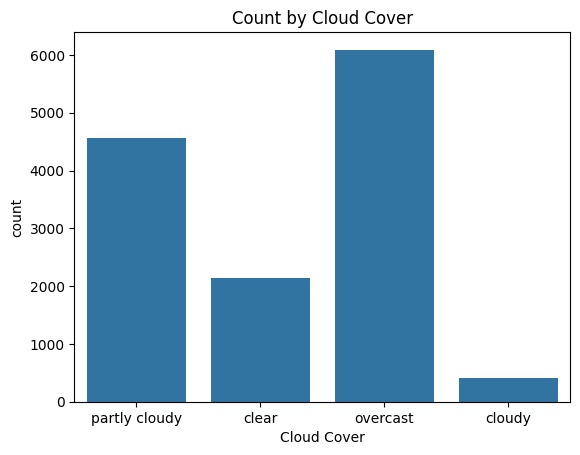

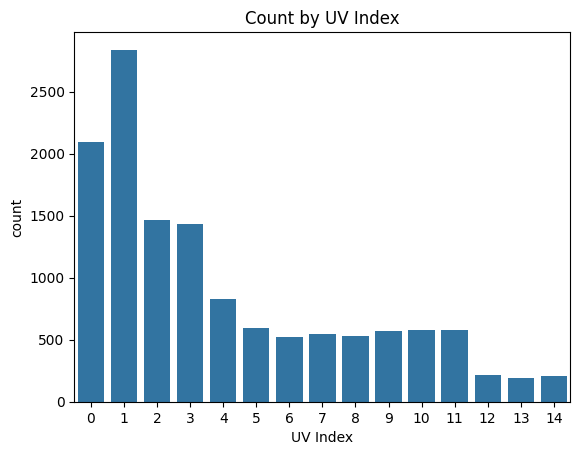

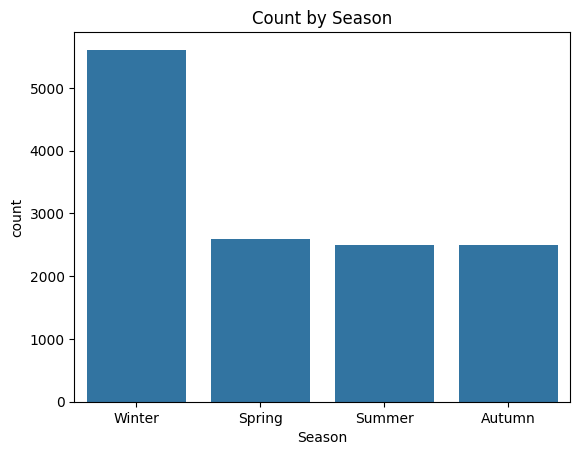

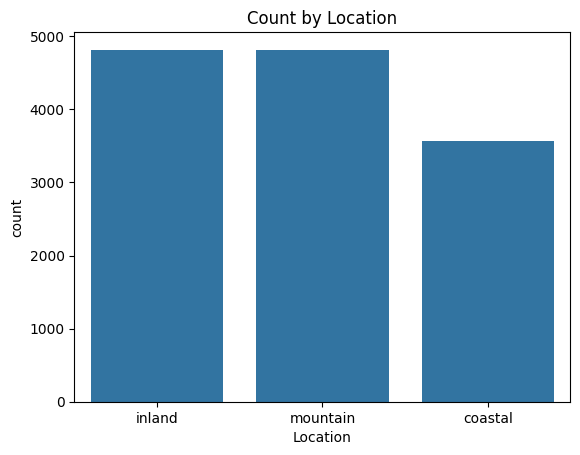

In [6]:
# plot distribution of discrete features

# Overcast conditions occurred most frequently, followed by partly cloudy, clear, and then cloudy skies.
# UV Index values are most commonly low, with frequency decreasing as the index increases.
# Winter had the highest observation count, while the other seasons had roughly equal and lower counts.
# Inland and mountain regions had similar and higher observation counts compared to coastal areas.
# All four weather types (Rainy, Cloudy, Sunny, and Snowy—had equal counts) showing a balanced distribution.

categorical_features = ['Cloud Cover', 'UV Index', 'Season', 'Location']

for cat in categorical_features:
    sns.countplot(data=df, x=cat)
    plt.title(f'Count by {cat}')
    plt.show()

# Pre-Processing

In [ ]:
# one-hot encoding
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
encoder.fit(df[categorical_features])
encoded = encoder.transform(df[categorical_features])
column_names = encoder.get_feature_names_out(categorical_features)
encoded_df = pd.DataFrame(encoded, columns=column_names, index=df.index)
non_categorical = df.drop(columns=categorical_features + ["Weather Type"])

# merge
processed_df = pd.concat([non_categorical, encoded_df], axis=1)

TypeError: unhashable type: 'list'

### Correcting issues with synthetic data
![Weatherman!](weatherman.png)

In [8]:
# remove precipitations over 100%

processed_df = processed_df[processed_df["Precipitation (%)"] <= 100]
processed_df["Precipitation (%)"].describe()

count    12808.000000
mean        52.072923
std         31.119669
min          0.000000
25%         19.000000
50%         56.000000
75%         80.000000
max        100.000000
Name: Precipitation (%), dtype: float64

In [9]:
processed_df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,Visibility (km),Weather Type,Cloud Cover_clear,Cloud Cover_cloudy,Cloud Cover_overcast,...,UV Index_12,UV Index_13,UV Index_14,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain
0,14.0,73,9.5,82.0,1010.82,3.5,Rainy,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,39.0,96,8.5,71.0,1011.43,10.0,Cloudy,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,30.0,64,7.0,16.0,1018.72,5.5,Sunny,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,38.0,83,1.5,82.0,1026.25,1.0,Sunny,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,27.0,74,17.0,66.0,990.67,2.5,Rainy,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [10]:
# count nulls
# data is synthetic so should be 0
processed_df.isnull().sum()

Temperature                  0
Humidity                     0
Wind Speed                   0
Precipitation (%)            0
Atmospheric Pressure         0
Visibility (km)              0
Weather Type                 0
Cloud Cover_clear            0
Cloud Cover_cloudy           0
Cloud Cover_overcast         0
Cloud Cover_partly cloudy    0
UV Index_0                   0
UV Index_1                   0
UV Index_2                   0
UV Index_3                   0
UV Index_4                   0
UV Index_5                   0
UV Index_6                   0
UV Index_7                   0
UV Index_8                   0
UV Index_9                   0
UV Index_10                  0
UV Index_11                  0
UV Index_12                  0
UV Index_13                  0
UV Index_14                  0
Season_Autumn                0
Season_Spring                0
Season_Summer                0
Season_Winter                0
Location_coastal             0
Location_inland              0
Location

In [11]:
# Removing temperature outliers
processed_df = processed_df[processed_df['Temperature'] < 56]

processed_df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,Visibility (km),Weather Type,Cloud Cover_clear,Cloud Cover_cloudy,Cloud Cover_overcast,...,UV Index_12,UV Index_13,UV Index_14,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain
0,14.0,73,9.5,82.0,1010.82,3.5,Rainy,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,39.0,96,8.5,71.0,1011.43,10.0,Cloudy,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,30.0,64,7.0,16.0,1018.72,5.5,Sunny,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,38.0,83,1.5,82.0,1026.25,1.0,Sunny,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,27.0,74,17.0,66.0,990.67,2.5,Rainy,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [13]:
# generate a basic correlation matrix to visualize relationships
# the previous dataset I collected had essentially no correlation between features

correlation_matrix = processed_df.corr()
# Plot heatmap for better visualization
plt.figure(figsize=(15, 9))
sns.heatmap(correlation_matrix, annot=True, cmap="inferno", fmt=".2f", linewidths=0.5)
plt.show()

# print 10 values with highest (absolute value) correlation
corr_abs = correlation_matrix.abs()
upper_triangle = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))
top10 = upper_triangle.unstack().sort_values(ascending=False).head(10)

print("Top 10 highest (absolute) correlations:")
print(top10)

ValueError: could not convert string to float: 'Rainy'

The correlations make logical sense, showing the dataset isn't completely random even though it's synthetic. This indicates we may be to train a useful model.

## Boxplots

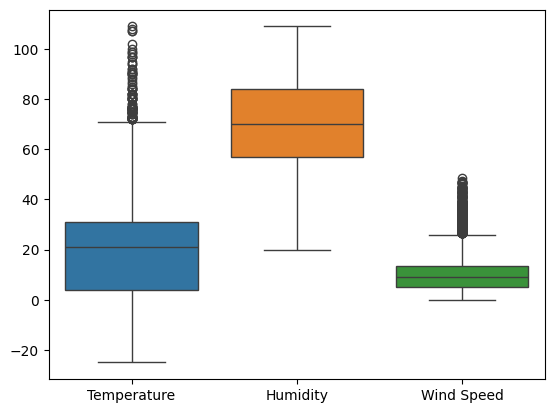

In [ ]:
sns.boxplot(data=df[['Temperature', 'Humidity', 'Wind Speed']])
plt.show()

#  Methods 

#  Evaluation 

# Impact